In [31]:
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import re 
from tqdm import tqdm
import seaborn as sns
from Bio import SeqIO
from Bio import SeqUtils
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from pandarallel import pandarallel
from sklearn.decomposition import PCA
import numpy as np

pandarallel.initialize()


INFO: Pandarallel will run on 44 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [5]:
%cd /workdir/hdd29/chloroplast_genome_evaluation

/local/workdir/hdd29/chloroplast_genome_evaluation


In [9]:
df = pd.read_csv("data/taxonomy_info.csv")


In [10]:
#get the genome sequence and compute length and GC
genomes_dir = "data/genomes"

def get_genome(fileBasename, genome_dir):
    genome_file = os.path.join(genome_dir, fileBasename + ".fa")
    if not os.path.exists(genome_file):
        print(f"Genome file {genome_file} does not exist.")
        return None, None
    
    genome_seq = SeqIO.read(genome_file, "fasta")
    return genome_seq.seq

df["Genome"] = df["FileBasename"].parallel_apply(lambda x: get_genome(x, genomes_dir))



In [12]:
df["genomeLength"] = df["Genome"].parallel_apply(lambda x: len(x) if x is not None else 0)
df["genomicGC"] = df["Genome"].parallel_apply(lambda x: SeqUtils.gc_fraction(x) if x is not None else 0)

In [15]:
#how many NA genomes, genomeLength, and genomic GC
df["Genome"].isna().sum()
df["genomeLength"].isna().sum()
df["genomicGC"].isna().sum()
df.describe()

,Year,genomeLength,genomicGC
count,53285.000000,5.328500e+04,53285.000000
mean,2022.188552,1.529782e+05,0.371794
std,2.218536,1.918020e+04,0.019058
min,1998.000000,1.160000e+02,0.137667
25%,2021.000000,1.513230e+05,0.366321
50%,2023.000000,1.555840e+05,0.373825
75%,2024.000000,1.591440e+05,0.380551
max,2025.000000,1.352306e+06,0.576640


Throw a flag on genome length - min and max present obvious grounds for filtering. 

Year looks pretty reasonable, in fact. 

In [ ]:
#gene presence/absence, then count
gbfs_dir = "data/gbfs"

def get_gene_names_from_gbf(gbf_file):
    """
    Count the number of gene features in a GenBank file.

    Parameters:
        gbf_file (str): Path to the GenBank file.

    Returns:
        list (str): List of gene names.
    """
    genes = []

    if not os.path.exists(gbf_file):
        print(f"GBF file {gbf_file} does not exist.")
        return genes

    for record in SeqIO.parse(gbf_file, "genbank"):
        for feature in record.features:
            if feature.type == "gene":
                genes += [feature.qualifiers.get("gene", [""])[0]]

    return genes

"""
for file in tqdm(df["FileBasename"].to_list()[1:10]):
    gbf_file = os.path.join(gbfs_dir, file + "fa.gbf")
    if not os.path.exists(gbf_file):
        print(f"GBF file {gbf_file} does not exist.")
        continue

    genes = get_gene_names_from_gbf(gbf_file)
"""

df["Genes"] = df["FileBasename"].parallel_apply(lambda x: get_gene_names_from_gbf(os.path.join(gbfs_dir, x + "fa.gbf")))

mlb = MultiLabelBinarizer()
gene_matrix = pd.DataFrame(
    mlb.fit_transform(df["Genes"]),
    columns=mlb.classes_,
    index=df.index
)
df = pd.concat([df, gene_matrix], axis=1)


GBF file data/gbfs/MK5603401fa.gbf does not exist.
GBF file data/gbfs/MK5603391fa.gbf does not exist.


In [25]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
gene_matrix = pd.DataFrame(
    mlb.fit_transform(df["Genes"]),
    columns=mlb.classes_,
    index=df.index
)
df = pd.concat([df, gene_matrix], axis=1)


In [26]:
df["geneCount"] = df[mlb.classes_].sum(axis=1)


In [28]:
df["geneCount"].describe()

count    53285.000000
mean       102.383579
std         15.086241
min          0.000000
25%        104.000000
50%        107.000000
75%        108.000000
max        112.000000
Name: geneCount, dtype: float64

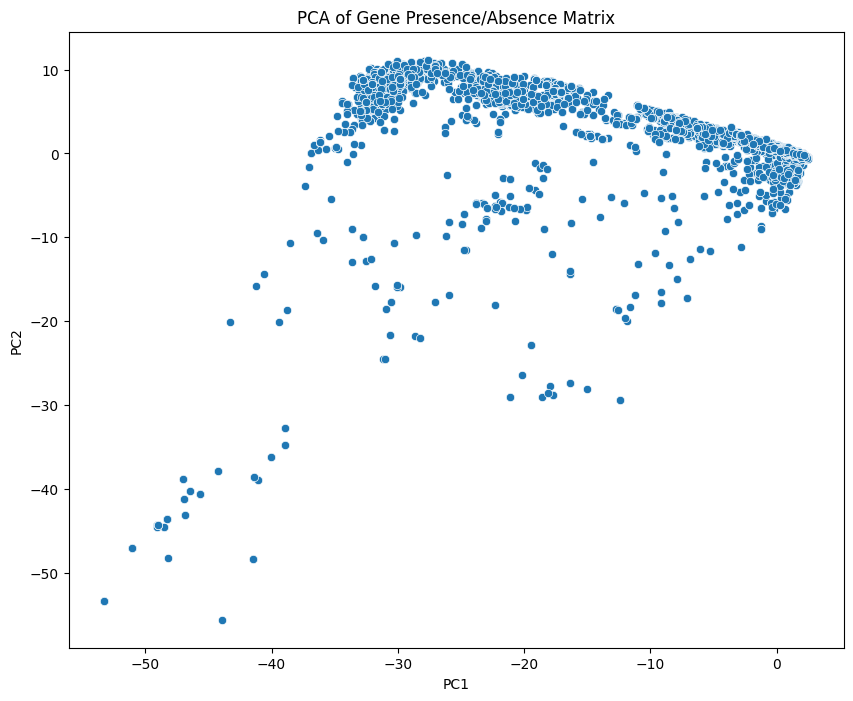

In [30]:
#perform a quick PCA on the gene presence/absence matrix to see if there are any obvious outliers
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
gene_data_scaled = scaler.fit_transform(df[mlb.classes_])
pca = PCA(n_components=2)
gene_data_pca = pca.fit_transform(gene_data_scaled)
df_pca = pd.DataFrame(gene_data_pca, columns=["PC1", "PC2"])
df_pca = pd.concat([df, df_pca], axis=1)
plt.figure(figsize=(10,8))
sns.scatterplot(data=df_pca, x="PC1", y="PC2")
plt.title("PCA of Gene Presence/Absence Matrix")
plt.show()

Looks Like gene loss/absence really explains some variation in the data, i would bet this is due to the inclusion of non-plant samples with wacky gene sets

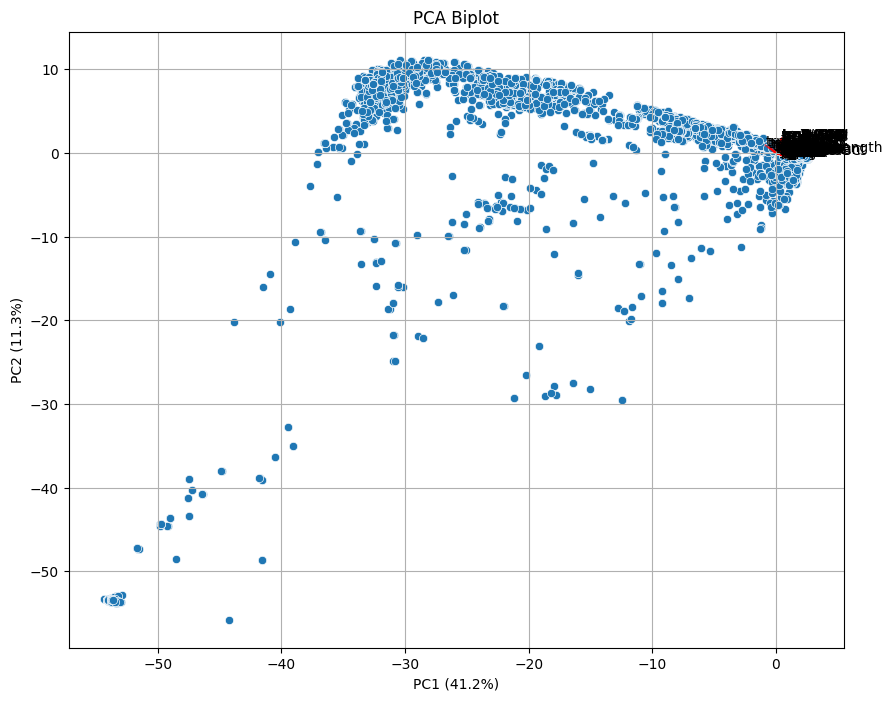

Variance explained: PC1=41.2%, PC2=11.3%
Columns included in PCA:
 ['Year', 'genomeLength', 'genomicGC', 'accD', 'atpA', 'atpB', 'atpE', 'atpF', 'atpH', 'atpI', 'ccsA', 'cemA', 'clpP', 'infA', 'matK', 'ndhA', 'ndhB', 'ndhC', 'ndhD', 'ndhE', 'ndhF', 'ndhG', 'ndhH', 'ndhI', 'ndhJ', 'ndhK', 'petA', 'petB', 'petD', 'petG', 'petL', 'petN', 'psaA', 'psaB', 'psaC', 'psaI', 'psaJ', 'psbA', 'psbB', 'psbC', 'psbD', 'psbE', 'psbF', 'psbH', 'psbI', 'psbJ', 'psbK', 'psbL', 'psbM', 'psbN', 'psbT', 'psbZ', 'rbcL', 'rpl14', 'rpl16', 'rpl2', 'rpl20', 'rpl22', 'rpl23', 'rpl32', 'rpl33', 'rpl36', 'rpoA', 'rpoB', 'rpoC1', 'rpoC2', 'rps11', 'rps12', 'rps14', 'rps15', 'rps16', 'rps18', 'rps19', 'rps2', 'rps3', 'rps4', 'rps7', 'rps8', 'rrn16S', 'rrn23S', 'rrn4.5S', 'rrn5S', 'trnA-UGC', 'trnC-GCA', 'trnD-GUC', 'trnE-UUC', 'trnF-GAA', 'trnG-GCC', 'trnG-UCC', 'trnH-GUG', 'trnI-AAU', 'trnI-GAU', 'trnK-UUU', 'trnL-CAA', 'trnL-GAG', 'trnL-UAA', 'trnL-UAG', 'trnM-CAU', 'trnN-GUU', 'trnP-GGG', 'trnP-UGG', 'trnQ-UUG'

In [ ]:
num_df = df.select_dtypes(include=[np.number])
scaled = StandardScaler().fit_transform(num_df)
pca = PCA(n_components=2)
scores = pca.fit_transform(scaled)

plt.figure(figsize=(10,8))
sns.scatterplot(x=scores[:,0], y=scores[:,1])
scale = 20
for i, (x, y) in enumerate(zip(pca.components_[0], pca.components_[1])):
    plt.arrow(0, 0, x*scale, y*scale, color='r', alpha=0.5, head_width=0.05)
    plt.text(x*(scale+0.2), y*(scale+0.2), num_df.columns[i], fontsize=10)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA Biplot")
plt.grid(True)
plt.show()

print(f"Variance explained: PC1={pca.explained_variance_ratio_[0]*100:.1f}%, PC2={pca.explained_variance_ratio_[1]*100:.1f}%")
loadings = pd.DataFrame(pca.components_.T, index=num_df.columns, columns=["PC1", "PC2"])
print("Columns included in PCA:\n", num_df.columns.tolist())


So the first PC is loading on gene count, the second on a bunch of tRNAS 

Process the TRY data in R, since they have their own package for loading their data format

/workdir/hdd29/chloroplast_genome_evaluation/src/XXX_processTRYData.R

In [ ]:
#nitrogen status. Due to TRY data format we will do this in R

In [ ]:
#photosynthetic pathway 